<a href="https://colab.research.google.com/github/stenzr/product_classification/blob/master/colab_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading the Libraries

In [2]:
#Loading the libraries
import numpy as np
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
%matplotlib inline
import os
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 2. Data Exploration

In [3]:
#the path to the dataset
path = "/content/drive/MyDrive/projects/labellerrAssignment"
modelpath = path+"/saved_models/"
dataset = path+"/dataset/images/"
train_path = dataset+"train/"
test_path = dataset+"test/"

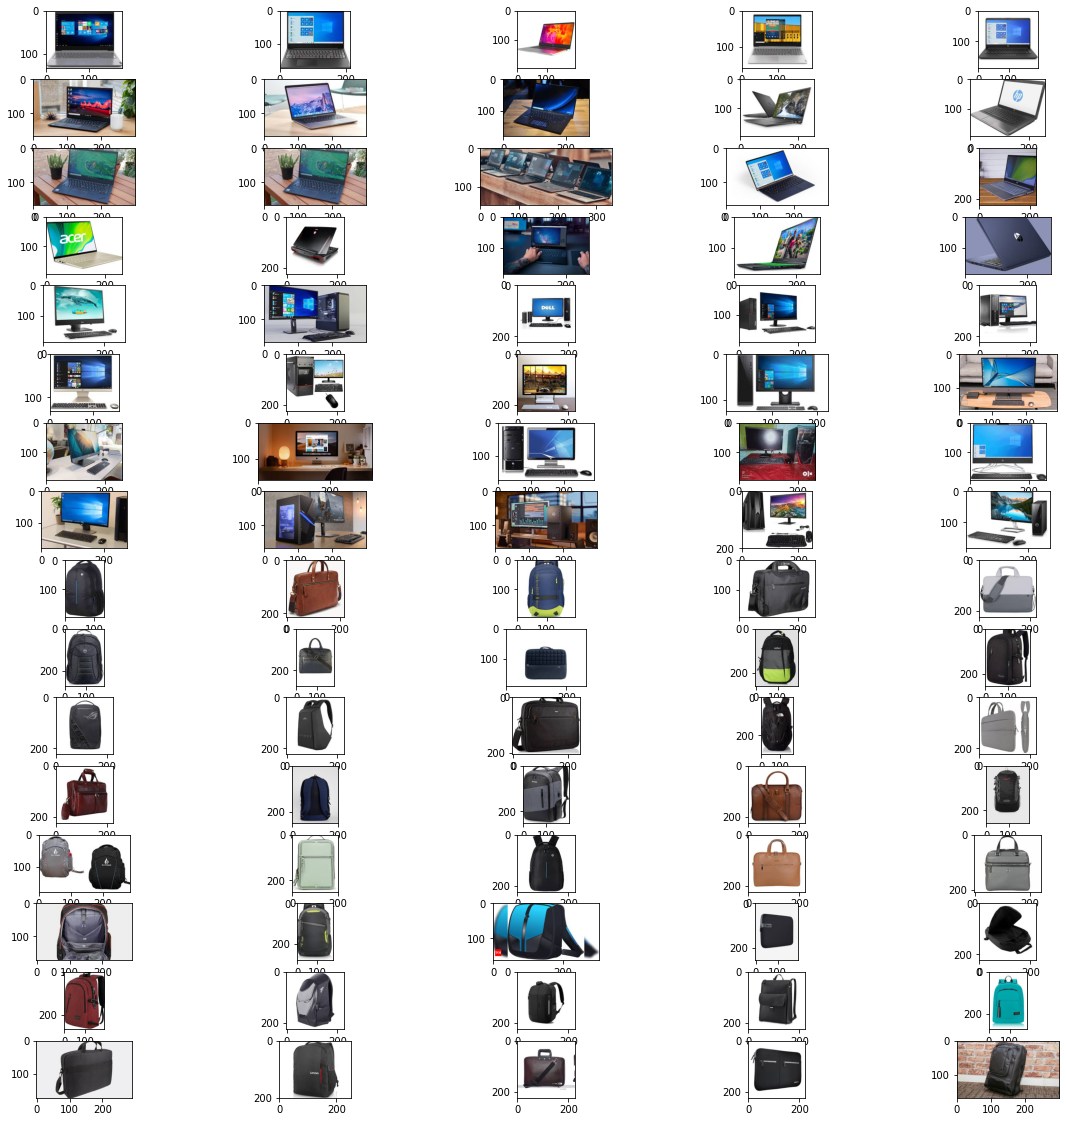

In [4]:
#plotting train images 
plt.figure(figsize=(20,20))
for i in range(1, 81):
  plt.subplot(16, 5, i)
  imageName = train_path+"image"+str(i)+".jpeg"
  image = imread(imageName)
  plt.imshow(image)

plt.show()

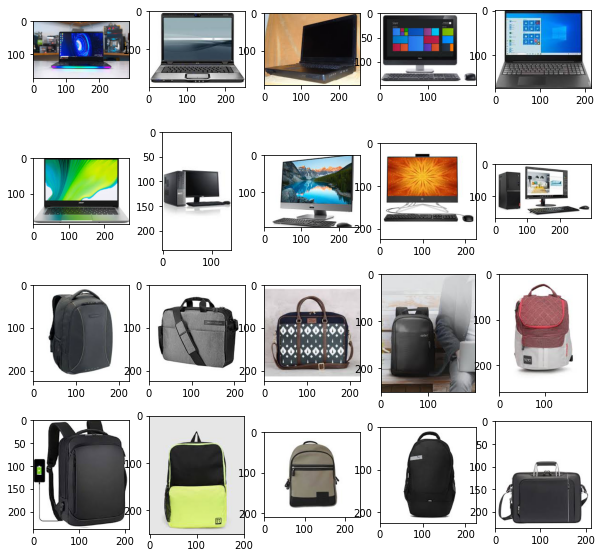

In [5]:
#plotting test images 
plt.figure(figsize=(10,10))
for i in range(1, 21):
  plt.subplot(4, 5, i)
  imageName = test_path+"test_image"+str(i)+".jpeg"
  image = imread(imageName)
  plt.imshow(image)

plt.show()

In [6]:
# defining the path to dataset label files
df_train = pd.read_csv(path+"/dataset/train.csv")
df_test = pd.read_csv(path+"/dataset/test.csv")

In [7]:
df_train.head()

,name,category
0,image1,0
1,image2,0
2,image3,0
3,image4,0
4,image5,0


In [8]:
df_test.head()

,name,category
0,test_image1,0
1,test_image2,0
2,test_image3,0
3,test_image4,0
4,test_image5,0


# 3. Data Wrangling

In [9]:
# Creating seperate folders for different labels for the ease of augmentation
labels=[0,1]
for i in range(len(labels)):
    k=str(i)
    os.mkdir(train_path+k)
    os.mkdir(test_path+k)

FileExistsError: ignored

In [10]:
# utility function to copy images to their label folders
def copyImage(df, path):
  for i in tqdm(range(len(df["name"]))):
    img=df["name"].iloc[i]
    if(df["category"].iloc[i]==0):
        shutil.copy(path+img+".jpeg",path+"0")
    elif(df["category"].iloc[i]==1):
        shutil.copy(path+img+".jpeg",path+"1")

In [11]:
# Copying the images to their respective label folders
copyImage(df_train, train_path)
copyImage(df_test, test_path)

print("\nCopying Files Done!!")

100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Copying Files Done!!


In [12]:
# Defining categories for the labels
categoryNames = {0:"PC",
                 1:"PCbag"}

In [13]:
# Replacing the numeric category labels with named categories
df_train['category'].replace(categoryNames, inplace=True)
df_test['category'].replace(categoryNames, inplace=True)

In [14]:
# A quick look at the dataset
df_train.head()

,name,category
0,image1,PC
1,image2,PC
2,image3,PC
3,image4,PC
4,image5,PC


In [15]:
df_test.head()

,name,category
0,test_image1,PC
1,test_image2,PC
2,test_image3,PC
3,test_image4,PC
4,test_image5,PC


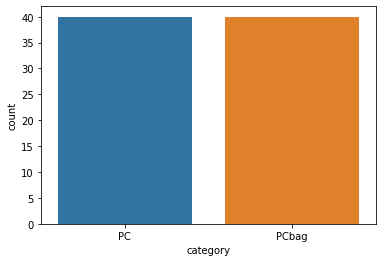

In [16]:
# Visualising the category label distribution for training dataset
sns.countplot(data=df_train, x='category')

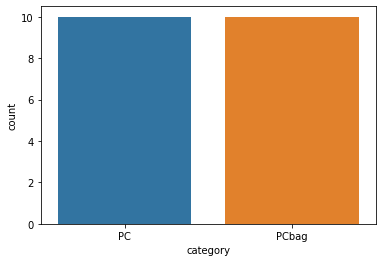

In [17]:
# Visualising the category label distribution for the testing dataset
sns.countplot(data=df_test, x='category')

In [18]:
#storing width and height of images
w = []
h = []
for i in range(1, 81):
  imageName = train_path+"image"+str(i)+".jpeg"
  image = imread(imageName)
  height, width, _ = image.shape
  w.append(width)
  h.append(height)

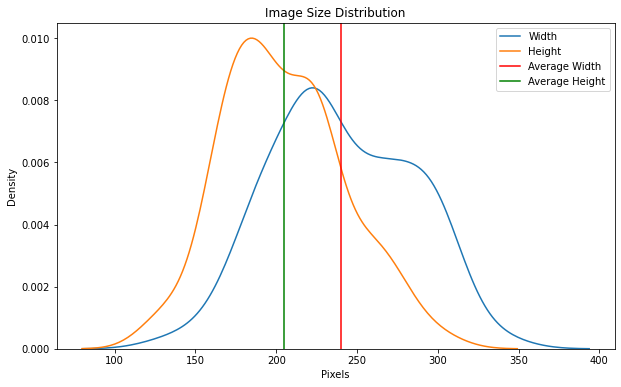

In [19]:
# Visualizing Image Size distribution
plt.figure(figsize=(10, 6))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
sns.kdeplot(w, label='Width')
sns.kdeplot(h, label='Height')
plt.axvline(np.mean(w),color='r',label='Average Width')
plt.axvline(np.mean(h), color='g',label='Average Height')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

In [20]:
# Calculating the average image size for further resizing of all the images
width = np.mean(w)
height = np.mean(h)

In [21]:
width, height

(240.2375, 204.775)

In [22]:
imgSize = [240, 205]

In [23]:
# Augmenting the images
train_datagen=ImageDataGenerator(rescale = 1/255,
                                 rotation_range=0.5,
                                 width_shift_range=0.3,
                                 shear_range = 0.2,
                                 height_shift_range=0.3,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1/255)


In [24]:
# Loading the augmented images for model training
training_set =train_datagen.flow_from_directory(train_path,
                                                target_size=imgSize,
                                                batch_size=5,
                                                class_mode='binary')
                                                 

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=imgSize,
                                            batch_size=5,
                                            class_mode='binary')
                                            

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


# 4. Defining Utility Functions

In [26]:
# plotting the loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.legend()
  plt.show()

In [27]:
# plotting the accuracy
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='train acc')
  plt.plot(history.history['val_accuracy'], label='val acc')
  plt.legend()
  plt.show()

# 5. Model Training

In [28]:
# Defining the number of training epochs
epochs = 50

## 5.1 CNN (1 convolution 1 pooling)

In [29]:
# Defining and Compiling Model1
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation = 'relu', input_shape= (240, 205, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))
model1.compile(loss='binary_crossentropy',
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001),metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 203, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 101, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 384608)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                24614976  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 24,615,937
Trainable params: 24,615,937
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Fitting the data on Model1
model1_history = model1.fit_generator(training_set,
                                      validation_data = test_set,
                                      #steps_per_epoch = len(train_generator) // 5,
                                      epochs = epochs)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
16/16 [==============================] - 6s 344ms/step - loss: 10.9166 - accuracy: 0.4273 - val_loss: 0.5628 - val_accuracy: 0.7000
Epoch 2/50
16/16 [==============================] - 5s 304ms/step - loss: 0.7991 - accuracy: 0.4738 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
16/16 [==============================] - 5s 302ms/step - loss: 0.6923 - accuracy: 0.4658 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 4/50
16/16 [==============================] - 5s 304ms/step - loss: 0.6812 - accuracy: 0.5373 - val_loss: 0.6715 - val_accuracy: 0.8000
Epoch 5/50
16/16 [==============================] - 5s 304ms/step - loss: 0.6396 - accuracy: 0.8247 - val_loss: 0.5938 - val_accuracy: 0.7500
Epoch 6/50
16/16 [==============================] - 5s 303ms/step - loss: 0.6218 - accuracy: 0.7117 - val_loss: 0.5469 - val_accuracy: 0.8000
Epoch 7/50
16/16 [==============================] - 5s 305ms/step - loss: 0.5561 - accuracy: 0.7569 - val_loss: 0.5660 - val_accuracy: 0.7500
Epoch

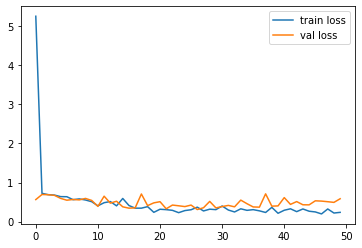

In [31]:
# Visualising the loss
plot_loss(model1_history)

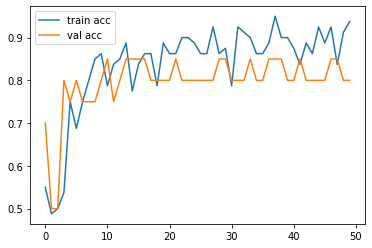

In [32]:
# Visualising the accuracy
plot_accuracy(model1_history)

In [33]:
# Calculating the test accuracy
_, accuracy1 = model1.evaluate_generator(test_set, steps=len(test_set), verbose=0)
accuracy1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.800000011920929

## 5.2 CNN (2 convolution 2 pooling )

In [34]:
# Defining and Compiling Model2
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation = 'relu', input_shape= (240, 205, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))
model2.compile(loss='binary_crossentropy',
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001),metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 203, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 99, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 58, 49, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 181888)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                11640896  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [35]:
# Fitting the data on Model2
model2_history = model2.fit_generator(training_set,
                                      validation_data = test_set,
                                      #steps_per_epoch = len(train_generator) // 5,
                                      epochs = epochs)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 [==============================] - 7s 404ms/step - loss: 2.3849 - accuracy: 0.5254 - val_loss: 0.5778 - val_accuracy: 0.6000
Epoch 2/50
16/16 [==============================] - 6s 394ms/step - loss: 0.6592 - accuracy: 0.6933 - val_loss: 0.5017 - val_accuracy: 0.7500
Epoch 3/50
16/16 [==============================] - 6s 389ms/step - loss: 0.4625 - accuracy: 0.8326 - val_loss: 0.6408 - val_accuracy: 0.6500
Epoch 4/50
16/16 [==============================] - 6s 391ms/step - loss: 0.3483 - accuracy: 0.8561 - val_loss: 0.4786 - val_accuracy: 0.8000
Epoch 5/50
16/16 [==============================] - 6s 390ms/step - loss: 0.5418 - accuracy: 0.7402 - val_loss: 0.2441 - val_accuracy: 0.8500
Epoch 6/50
16/16 [==============================] - 6s 389ms/step - loss: 0.3514 - accuracy: 0.8582 - val_loss: 0.3481 - val_accuracy: 0.8000
Epoch 7/50
16/16 [==============================] - 6s 390ms/step - loss: 0.2748 - accuracy: 0.8725 - val_loss: 0.3681 - val_accuracy: 0.8500
Epoch 8/50
16/16 

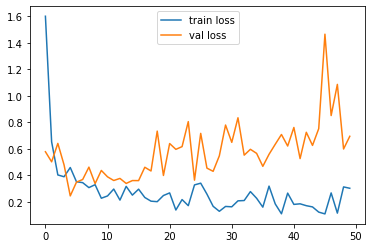

In [36]:
# Visualising the loss
plot_loss(model2_history)

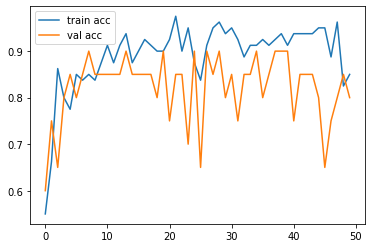

In [37]:
# Visualising the accuracy
plot_accuracy(model2_history)

In [38]:
# Calcuating the test accuracy
_, accuracy2 = model2.evaluate_generator(test_set, steps=len(test_set), verbose=0)
accuracy2

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.800000011920929

## 5.3 CNN (3 convolution 3 pooling)

In [39]:
# Defining and Compiling Model3
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation = 'relu', input_shape= (240, 205, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))
model3.compile(loss='binary_crossentropy',
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001),metrics = ['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 238, 203, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 119, 101, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 117, 99, 64)       18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 58, 49, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 23, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 82432)            

In [40]:
# Fitting the Data on Model3
model3_history = model3.fit_generator(training_set,
                                      validation_data = test_set,
                                      #steps_per_epoch = len(train_generator) // 5,
                                      epochs = epochs)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 [==============================] - 8s 482ms/step - loss: 1.4145 - accuracy: 0.4505 - val_loss: 0.6134 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 8s 471ms/step - loss: 0.6201 - accuracy: 0.6418 - val_loss: 0.4658 - val_accuracy: 0.8000
Epoch 3/50
16/16 [==============================] - 8s 472ms/step - loss: 0.5773 - accuracy: 0.7834 - val_loss: 0.4685 - val_accuracy: 0.7500
Epoch 4/50
16/16 [==============================] - 8s 471ms/step - loss: 0.6729 - accuracy: 0.7698 - val_loss: 0.6242 - val_accuracy: 0.5500
Epoch 5/50
16/16 [==============================] - 8s 473ms/step - loss: 0.7136 - accuracy: 0.5499 - val_loss: 0.5530 - val_accuracy: 0.6500
Epoch 6/50
16/16 [==============================] - 8s 472ms/step - loss: 0.5276 - accuracy: 0.8073 - val_loss: 0.4502 - val_accuracy: 0.7500
Epoch 7/50
16/16 [==============================] - 8s 475ms/step - loss: 0.4197 - accuracy: 0.7534 - val_loss: 0.5730 - val_accuracy: 0.7500
Epoch 8/50
16/16 

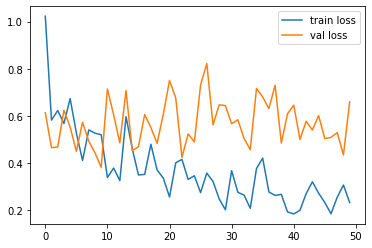

In [41]:
# Visualising the loss
plot_loss(model3_history)

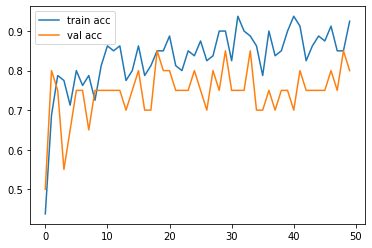

In [42]:
# Visualising the accuracy
plot_accuracy(model3_history)

In [43]:
# Calculating the test accuracy
_, accuracy3 = model3.evaluate_generator(test_set, steps=len(test_set), verbose=0)
accuracy3

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.800000011920929

## 5.4 CNN (Transfer Learning)

In [44]:
# Using ResNet50 for transfer learning
# loading the weights and removing the final output layer
resnet = ResNet50(input_shape=imgSize + [3], weights='imagenet', include_top=False)
# freesing the training of weights for inner layers
for i in resnet.layers:
    i.trainable=False
# Adding the output layer
x = Flatten()(resnet.output)
prediction = Dense(1, activation='sigmoid')(x)
model5 = Model(inputs=resnet.input, outputs=prediction)
model5.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 205, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 211, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 103, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 120, 103, 64) 256         conv1_conv[0][0]                 
_____________________________

In [45]:
# Compiling the model (Resnet50 transfered weights)
model5.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [46]:
# Fitting the data on Model5 to train tha final outer output layer
model5_history = model5.fit_generator(training_set,
                                      validation_data = test_set,
                                      #steps_per_epoch = len(train_generator) // 5,
                                      epochs = epochs)           

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
16/16 [==============================] - 19s 998ms/step - loss: 2.7543 - accuracy: 0.5940 - val_loss: 1.7112 - val_accuracy: 0.5500
Epoch 2/50
16/16 [==============================] - 15s 940ms/step - loss: 0.7422 - accuracy: 0.7234 - val_loss: 0.9561 - val_accuracy: 0.6500
Epoch 3/50
16/16 [==============================] - 15s 939ms/step - loss: 0.8255 - accuracy: 0.6731 - val_loss: 0.5566 - val_accuracy: 0.8000
Epoch 4/50
16/16 [==============================] - 15s 937ms/step - loss: 1.0290 - accuracy: 0.6334 - val_loss: 0.7038 - val_accuracy: 0.7000
Epoch 5/50
16/16 [==============================] - 15s 937ms/step - loss: 0.4216 - accuracy: 0.8274 - val_loss: 1.4432 - val_accuracy: 0.7000
Epoch 6/50
16/16 [==============================] - 15s 938ms/step - loss: 0.5928 - accuracy: 0.7476 - val_loss: 1.1791 - val_accuracy: 0.7500
Epoch 7/50
16/16 [==============================] - 15s 940ms/step - loss: 0.4036 - accuracy: 0.8212 - val_loss: 0.7515 - val_accuracy: 0.6000

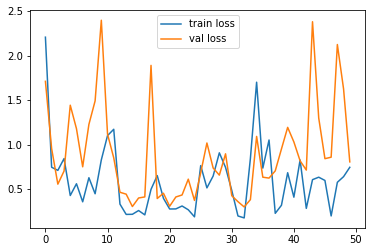

In [47]:
# Visualising the loss
plot_loss(model5_history)

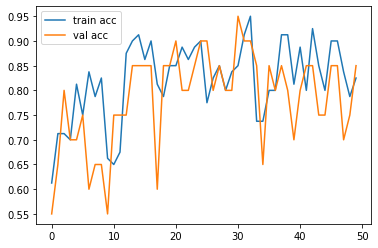

In [48]:
# Visualising the accuracy
plot_accuracy(model5_history)

In [49]:
# Calculating the test accuracy
_, accuracy5 = model5.evaluate_generator(test_set, steps=len(test_set), verbose=0)
accuracy5

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.8500000238418579

# 6. Final Results

In [52]:
# Compilin the results
models = ['CNN 1 layer', 'CNN 2 layers', 'CNN 3 layers', 'CNN (transfer learning)']
model_accuracy = [accuracy1, accuracy2, accuracy3, accuracy5]

In [56]:
data = [models, model_accuracy]
column_names = ['model', 'accuracy']

report = pd.DataFrame(np.column_stack(data), columns=column_names)

In [57]:
report

,model,accuracy
0,CNN 1 layer,0.800000011920929
1,CNN 2 layers,0.800000011920929
2,CNN 3 layers,0.800000011920929
3,CNN (transfer learning),0.8500000238418579
